<a href="https://colab.research.google.com/github/Ziyadamin/Debt-Recovery-for-Bank-Collection-Using-Regression-Discontinuity/blob/main/MiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Initial Exploration


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/bank_debt_data.csv')

In [ ]:
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


In [ ]:
df.shape

(1882, 6)

In [ ]:
df.isnull().sum()

,0
id,0
expected_recovery_amount,0
actual_recovery_amount,0
recovery_strategy,0
age,0
sex,0


In [ ]:
df.duplicated().sum()

0

In [ ]:

df = df.drop('id', axis=1)


# Visualizing Data Distributions


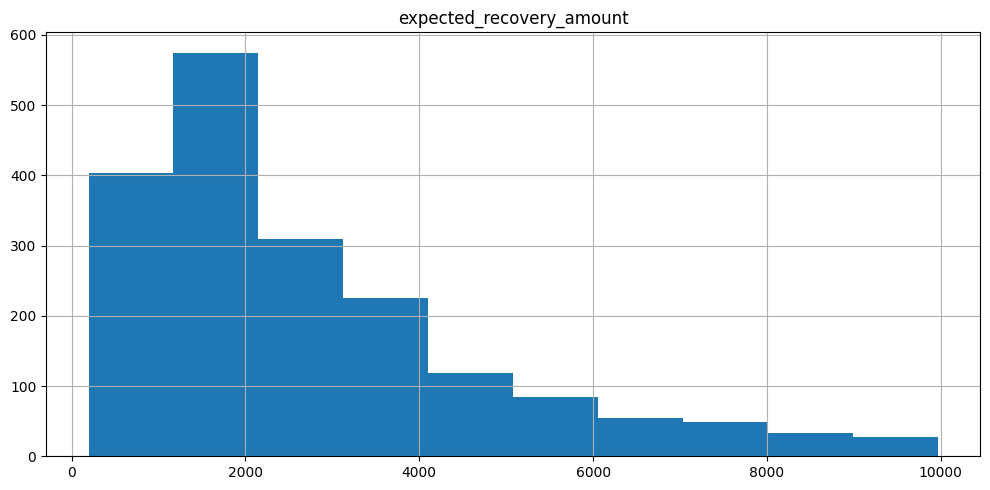

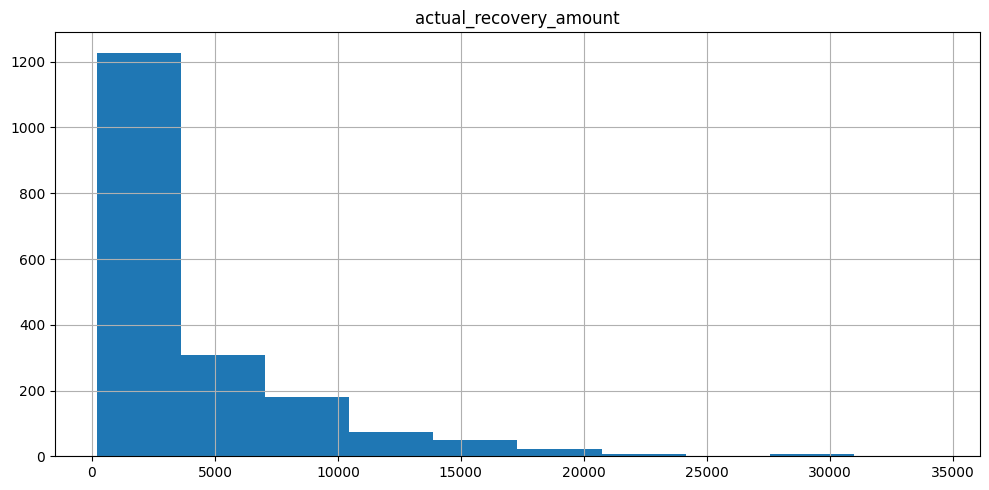

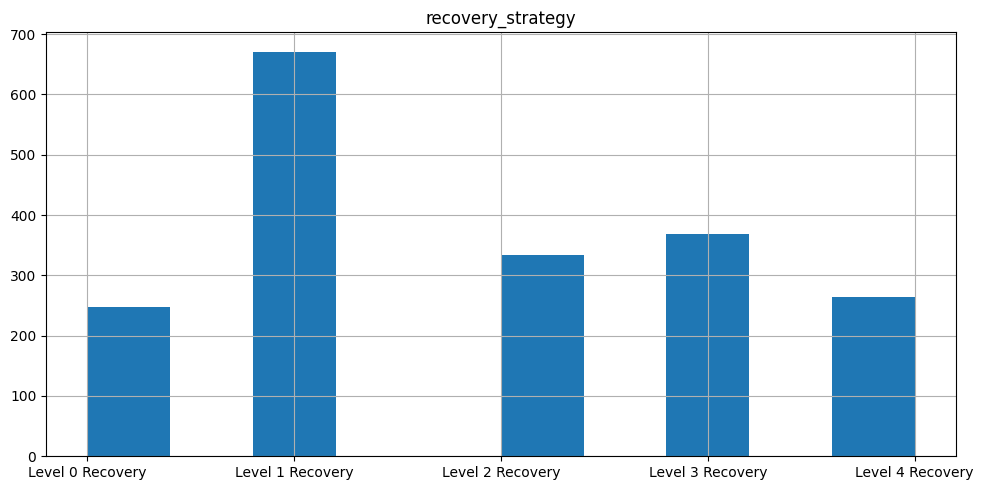

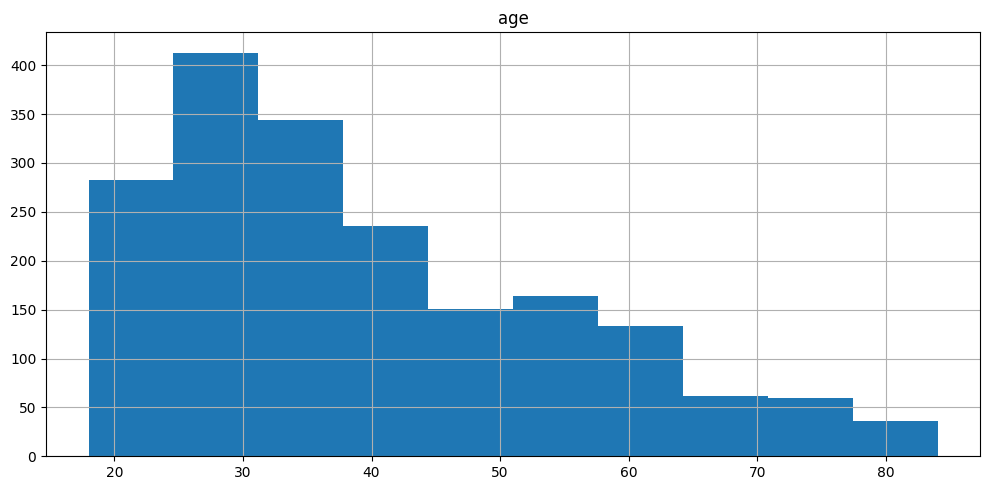

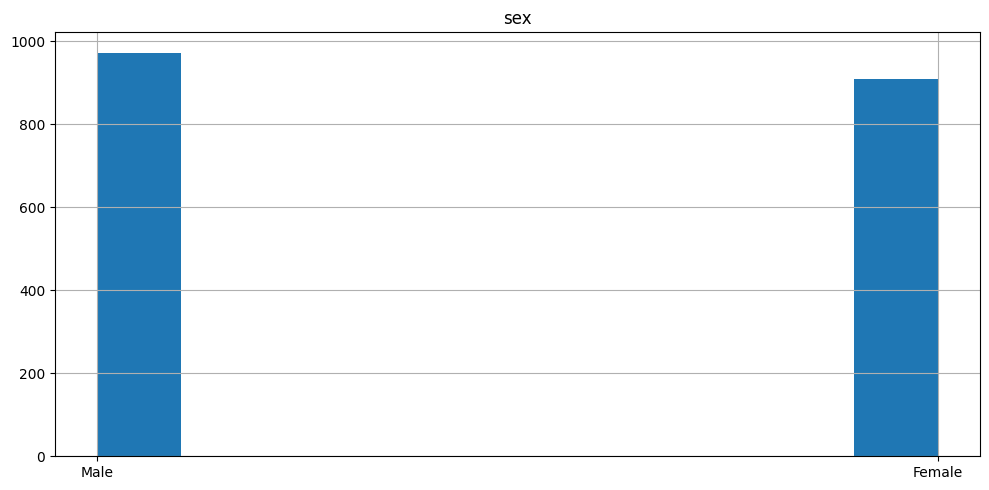

In [ ]:
import matplotlib.pyplot as plt

def plot_distributions(df):
  for col in df.columns:
     plt.figure(figsize=(10, 5))
     df[col].hist()
     plt.title(col)
     plt.tight_layout()
     plt.show()

plot_distributions(df)


In [ ]:
def print_distribution(df, feature):

  distribution = df[feature].value_counts(normalize=True)
  print(f"Distribution of {feature}:\n{distribution}")

# Example usage:
print_distribution(df, 'recovery_strategy')

Distribution of recovery_strategy:
recovery_strategy
Level 1 Recovery    0.356004
Level 3 Recovery    0.195537
Level 2 Recovery    0.176939
Level 4 Recovery    0.140276
Level 0 Recovery    0.131243
Name: proportion, dtype: float64


# Encoding Categorical Features


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'recovery_strategy' column
df['recovery_strategy'] = label_encoder.fit_transform(df['recovery_strategy'])

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'recovery_strategy' column
df['sex'] = label_encoder.fit_transform(df['sex'])

In [ ]:
df.head(400)

,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,194,263.540000,0,19,1
1,486,416.090000,0,25,0
2,527,429.350000,0,27,1
3,536,296.990000,0,25,1
4,541,346.385000,0,34,1
...,...,...,...,...,...
395,1164,1097.386145,1,34,1
396,1165,655.047004,1,33,0
397,1165,1139.893166,1,22,1
398,1168,681.279973,1,22,0


# Exploring Relationships with Scatter Plots


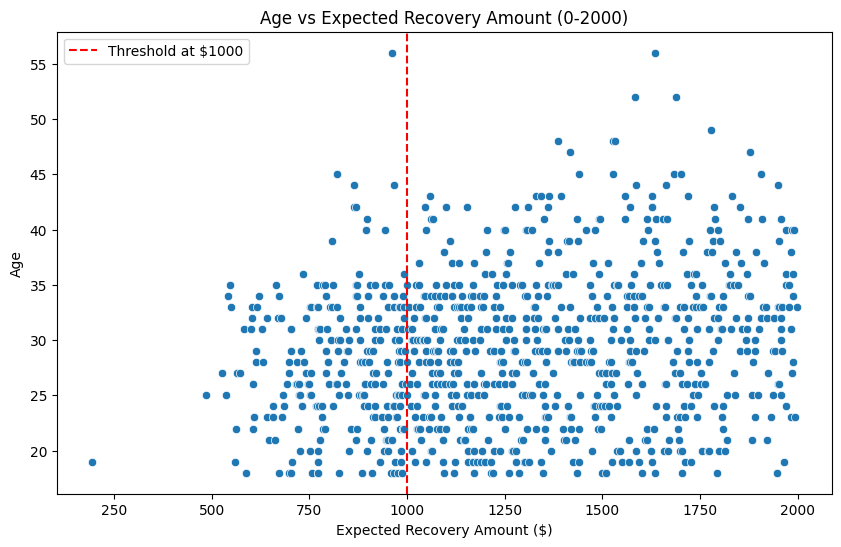

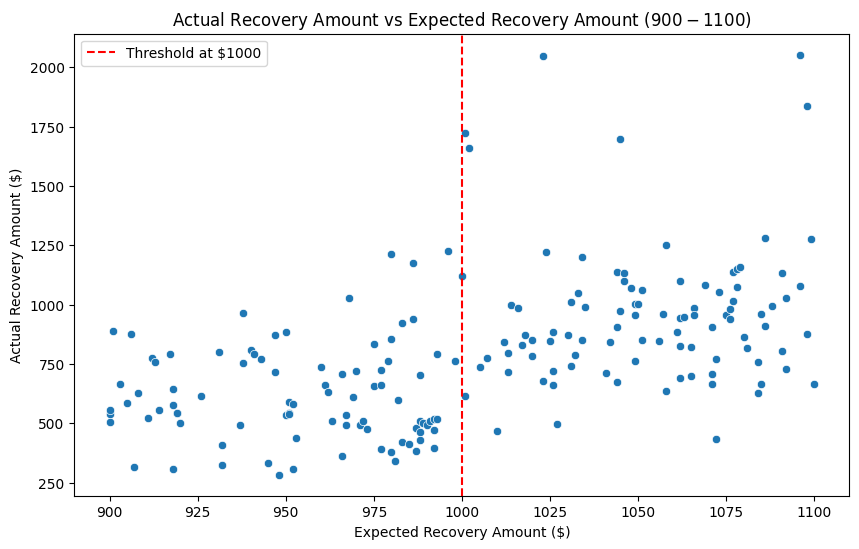

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='expected_recovery_amount', y='age', data=df[(df['expected_recovery_amount'] <= 2000)])
plt.axvline(x=1000, color='red', linestyle='--', label='Threshold at $1000')
plt.title('Age vs Expected Recovery Amount (0-2000)')
plt.xlabel('Expected Recovery Amount ($)')
plt.ylabel('Age')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x='expected_recovery_amount', y='actual_recovery_amount', data=df[(df['expected_recovery_amount'] >= 900) & (df['expected_recovery_amount'] <= 1100)])
plt.axvline(x=1000, color='red', linestyle='--', label='Threshold at $1000')
plt.title('Actual Recovery Amount vs Expected Recovery Amount ($900-$1100)')
plt.xlabel('Expected Recovery Amount ($)')
plt.ylabel('Actual Recovery Amount ($)')
plt.legend()
plt.show()

# Identifying and Handling Skewness


In [ ]:
def skew_features(df):

    skewness = {}
    for feature in df.columns:
        skewness[feature] = df[feature].skew()
    return skewness

skewness_values = skew_features(df)

skewed_features = [feature for feature, skew in skewness_values.items() if abs(skew) > 0.5]

print("Skewed features:", skewed_features)

Skewed features: ['expected_recovery_amount', 'actual_recovery_amount', 'age']


In [ ]:
# Create threshold indicator
df['above_threshold'] = (df['expected_recovery_amount'] > 1000).astype(int)

# Calculate the distribution
distribution = df['above_threshold'].value_counts(normalize=True)
print(f"Distribution of above_threshold:\n{distribution}")


Distribution of above_threshold:
above_threshold
1    0.868757
0    0.131243
Name: proportion, dtype: float64


# Building a Linear Regression Model


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Filter data around the log-transformed threshold
df_filtered = df[(df['expected_recovery_amount'] >= 900) & (df['expected_recovery_amount'] <= 1100)]

# Separate features (X) and target variable (y) for the filtered data
X = df_filtered[['expected_recovery_amount']]
y = df_filtered['actual_recovery_amount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 55989.09553702173
R-squared: 0.36987127910669393


In [ ]:
df.head()

,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex,above_threshold
0,194,263.540,0,19,1,0
1,486,416.090,0,25,0,0
2,527,429.350,0,27,1,0
3,536,296.990,0,25,1,0
4,541,346.385,0,34,1,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Calculate the log-transformed threshold values
#lower_threshold = np.log1p(900)
#upper_threshold = np.log1p(1100)

# Filter data around the log-transformed threshold
df_filtered = df[(df['expected_recovery_amount'] >= 900) & (df['expected_recovery_amount'] <= 1100)]

# Separate features (X) and target variable (y) for the filtered data
X = df_filtered[['expected_recovery_amount', 'above_threshold']]
y = df_filtered['actual_recovery_amount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f'Intercept: {intercept}')
print(f'Coefficients: {coefficients}')

Mean Squared Error: 48076.196064269214
R-squared: 0.4589269278093214
Intercept: -71.20539113444079
Coefficients: [  0.75836547 221.76633772]


In [ ]:
# Adding a constant for the intercept
X_const = sm.add_constant(X)

# Fitting the regression model with statsmodels
model_sm = sm.OLS(y, X_const).fit()

# Viewing the summary of the model
print(model_sm.summary())

# Extracting the coefficient for above_threshold
above_threshold_coef = model_sm.params['above_threshold']
p_value = model_sm.pvalues['above_threshold']

print(f'Coefficient for above_threshold: {above_threshold_coef}')
print(f'P-value for above_threshold: {p_value}')


                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.298
Model:                                OLS   Adj. R-squared:                  0.290
Method:                     Least Squares   F-statistic:                     38.44
Date:                    Sun, 06 Oct 2024   Prob (F-statistic):           1.22e-14
Time:                            12:31:23   Log-Likelihood:                -1280.7
No. Observations:                     184   AIC:                             2567.
Df Residuals:                         181   BIC:                             2577.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

#Final result, deciding if the 50$ dollar increase is worth it or not

In [ ]:
# Checking significance
alpha = 0.05
if p_value < alpha:
    print("The coefficient is statistically significant.")
else:
    print("The coefficient is not statistically significant.")

# Interpretation of the coefficient
if above_threshold_coef > 50:
    print(f"The additional recovery amount is on average ${above_threshold_coef:.2f}, which exceeds the extra cost of $50. The effort is justified.")
else:
    print(f"The additional recovery amount is on average ${above_threshold_coef:.2f}, which does not exceed the extra cost of $50. The effort may not be justified.")


The coefficient is statistically significant.
The additional recovery amount is on average $256.34, which exceeds the extra cost of $50. The effort is justified.
